In [383]:
DEBATE_URL = 'http://www.presidency.ucsb.edu/debates.php'
Q_DENSITY_CUTOFF = .0014
last_fetched_at = None
import json
import matplotlib.pyplot as plt
import urllib.request, time, re, random, hashlib
import bs4
import time
import sys
import nltk
import nltk.data
from itertools import combinations
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.corpus import wordnet
from nltk import bigrams
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine
import pandas as pd
import numpy as np
from scipy.spatial import distance
import time
import copy
SAVE_FILE = 'text_dict.json'
%matplotlib inline

In [261]:
def fetch(url):
    """Load the url compassionately."""
    
    global last_fetched_at
    
    url_hash = hashlib.sha1(url.encode()).hexdigest()
    filename = 'cache/cache-file-{}'.format(url_hash)
    try:
        with open(filename, 'r') as f:
            result = f.read()
            if len(result) > 0:
                #print("Retrieving from cache:", url)
                return result
    except:
        pass
    
    #print("Loading:", url)
    wait_interval = random.randint(3000,10000)
    if last_fetched_at is not None:
        now = time.time()
        elapsed = now - last_fetched_at
        if elapsed < wait_interval:
            time.sleep((wait_interval - elapsed)/1000)
        
    user_agent = 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)'
    headers = { 'User-Agent' : user_agent }
    req = urllib.request.Request(url, headers = headers)
    last_fetched_at = time.time()
    with urllib.request.urlopen(req) as response:
        result = str(response.read())
        with open(filename, 'w') as f:
            f.write(result)
    
        return result

In [279]:
def debate_processing(soup):
    return_list = []
    tables = soup.find_all('table')
    
    for table in tables:
        if table['width'] == '700' and table['bgcolor'] == "#FFFFFF":
            actual_table = table
    rows = actual_table.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        
        cols = [x.text.strip() for x in cols]
        try:
            link = row.find('a')['href']
            cols.append(link)
            return_list.append(cols)
        except:
            pass

    return return_list

In [263]:
def get_words_from_speech(link):
    result = fetch(link)
    soup = bs4.BeautifulSoup(result,'lxml')
    return soup

In [301]:
def get_debate_dict():
    result = fetch(DEBATE_URL)
    soup = bs4.BeautifulSoup(result,'lxml')
    debate_list = debate_processing(soup)
    debate_dict = {}
    for debate in debate_list:

        if ' ' not in debate[0]:
            debate = debate[1:]
        debate_id = ' '.join(debate[:2])
        try:
            clean_time = debate[0].replace('th,',',').replace('st,',',').replace('rd,',',').replace('nd,',',')
            debate_datetime = time.strptime(clean_time,'%B %d, %Y')
            
        except:
            debate_datetime = None
            print(debate,'*********')

        debate_dict[debate_id] = {}
        debate_dict[debate_id]['link'] = debate[2]
        debate_dict[debate_id]['time'] = debate_datetime 
        
        try:
            debate_dict[debate_id]['soup'] = get_words_from_speech(debate[2])
        except:
            debate_dict[debate_id]['soup'] = None
        
    return debate_dict

In [265]:
def find_politician_names(debate_dict):
    for key in debate_dict.keys():
        raw = get_soup_text(debate_dict[key])
        raw = raw.replace("--", ". ")
        sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
        sents = sent_detector.tokenize(raw.strip())

        #find candidate names, most commonly repeated first words of sentences, not common words
        colon_names = []
        period_names = []

        #get names from before colons
        for sent in sents:
            if ':' in sent:
                sent = sent.split(':')
                possible_name = sent[0] + ":"
                possible_name_no_paren = remove_paren(possible_name).strip()
                if (len(possible_name_no_paren)<25) & (len(possible_name_no_paren)>2):
                    colon_names.append(possible_name_no_paren)

        fdist1 = FreqDist(colon_names)
        fdist1_above_5 = [name[0] for name in fdist1.most_common(15) if name[1]>5]
        
        #get names before periods
        for sent in sents:
            if len(nltk.word_tokenize(sent))<5:
                possible_name = sent
                possible_name_no_paren = remove_paren(possible_name).strip()
                if (len(possible_name_no_paren)<25) & (len(possible_name_no_paren)>2):
                    period_names.append(possible_name_no_paren)
                    
        fdist2 = FreqDist(period_names)
        fdist2_above_15 = [name[0] for name in fdist2.most_common(15) if name[1]>15]
    
        #add names to dict
        colon_name_highest_freq = fdist1.most_common(1)[0][1]
        if colon_name_highest_freq > 20 :
            debate_dict[key]['names'] = fdist1_above_5
        else:
            debate_dict[key]['names'] = fdist2_above_15
            
    return debate_dict

In [266]:
def get_soup_text(dbt):
    raw = dbt['soup'].get_text()
    raw = raw.replace("\\", "")
    raw = raw.replace(".", ". ")
    raw = raw.replace("?", "? ")
    raw = raw.replace("!", "! ")
    raw = raw.replace("  ", " ")
    raw = raw.replace("-", "- ")
    raw = raw.replace("…", ". ")
    raw = raw.replace("...", ". ")
    return raw
    

In [267]:
def remove_paren(name):
    return_name = ''
    skip1c = 0
    skip2c = 0
    for i in name:
        if i == '[':
            skip1c += 1
        elif i == '(':
            skip2c += 1
        elif i == ']' and skip1c > 0:
            skip1c -= 1
        elif i == ')'and skip2c > 0:
            skip2c -= 1
        elif skip1c == 0 and skip2c == 0:
            return_name += i
    return return_name

In [268]:
def remove_non_politicians(cand_text_dict):
    for year in cand_text_dict.keys():
        for cand in cand_text_dict[year].keys():
            cand_text_dict[year][cand]['q_density'] = 0
            text = cand_text_dict[year][cand]['full_text']
            num_chars = len(list(text))
            num_q_marks = text.count('?')
            if num_chars > 0:
                cand_text_dict[year][cand]['q_density'] = num_q_marks/num_chars

    cand_text_dict_no_mod = copy.deepcopy(cand_text_dict)
    #remove liekly moderators
    for year in cand_text_dict.keys():
        for cand in cand_text_dict[year].keys():
            if ((cand == 'MALE' and 'MALE' in cand_text_dict_no_mod[year]) or 
                (cand == 'UNKNOWN' and 'UNKNOWN' in cand_text_dict_no_mod[year]) or 
                (cand == 'WRITE' and 'WRITE' in cand_text_dict_no_mod[year])):
                del cand_text_dict_no_mod[year][cand]
    
            if (cand_text_dict[year][cand]['q_density'] > Q_DENSITY_CUTOFF):
                if (cand in cand_text_dict_no_mod[year]):
                    del cand_text_dict_no_mod[year][cand]

        
    return cand_text_dict_no_mod

In [269]:
 def clean_dirty_name_lookup(names):
    
    lookup_dict = {}
    
    for name in names:
        clean_name = name.split()[-1].upper().replace('.','').replace(')','').replace(';','').replace(':','')
        lookup_dict[name] = clean_name
    
    return lookup_dict

In [270]:
def get_election_year(year, dbt):
    year = dbt['time'].tm_year
    year_mod = year % 4
    if year_mod == 0:
        election_year = year
    else:
        election_year = year + (4 - year_mod)
    return election_year

In [283]:
def clean_names(debate_dict):
    # Add debate year
    name_years = {}
    for dbt in debate_dict.keys():
        time = debate_dict[dbt]['time']

        # Get election year
        if time:
            election_year = get_election_year(time.tm_year, debate_dict[dbt])
        else:
            election_year = 'dbt'
        debate_dict[dbt]['election_year'] = election_year

        # Add new set of names from debate to name_years dict
        if election_year not in name_years:
            name_years[election_year] = {'names':set()}

        names = set(debate_dict[dbt]["names"])
        name_years[election_year]['names'] = name_years[election_year]['names'].union(names)

    # Reduce all names in one year to a single name
    for year in name_years:
        name_years[year]['lookup'] = clean_dirty_name_lookup(name_years[year]['names'])

    # Add lookup dictionary to debate dictionary
    for dbt in debate_dict.keys():
        election_year = debate_dict[dbt]['election_year']
        debate_dict[dbt]['lookup'] = name_years[election_year]['lookup']
        debate_dict[dbt]['clean_names'] = debate_dict[dbt]['lookup'].values()
    
    return debate_dict

In [272]:
def attribute_text(debate_dict):
    #make year/candidate dictionary for text
    cand_text_dict = {}
    for dbt in debate_dict.keys():
        year = debate_dict[dbt]['election_year']
        cand_text_dict[year] = {}
        for cand in debate_dict[dbt]["clean_names"]:
            cand_text_dict[year][cand] = {}
            cand_text_dict[year][cand]['full_text'] = ""
    
    #fill year/candidate dictionary
    for dbt in debate_dict.keys():
        #set variables
        year = debate_dict[dbt]["election_year"]
        names = debate_dict[dbt]["names"]
        if "write" in names:
            names.remove('write')
        
        #get debate soup
        raw = get_soup_text(debate_dict[dbt])
        
        #tokenize sents
        for name in names:
            raw = raw.replace(name, ". " + name)
        sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
        sents = sent_detector.tokenize(raw.strip())
        
        #loop through sents
        current_speaker = ""
        got_first_speaker = False
        for sent in sents:
            new_speaker = (len([name for name in names if name in sent])>0)
            if(new_speaker):
                got_first_speaker = True
                current_speaker_dirty = [name for name in names if name in sent][0]
                current_speaker = debate_dict[dbt]["lookup"][current_speaker_dirty]
            
            if(got_first_speaker):
                sent_no_name = sent.replace(current_speaker_dirty, "")
                cand_text_dict[year][current_speaker]['full_text'] = (cand_text_dict[year][current_speaker]['full_text'] + " " + sent_no_name)

    return cand_text_dict

In [273]:
def similarity_model(cand_text_dict):
    dumbWords = stopwords.words('english')
    political_positions = ['Governor', 'Senator', 'President']
    
    
    #loop through election years
    for year in cand_text_dict.keys():
        #loop through candidates
        for cand in cand_text_dict[year].keys():
            #print(year, cand)
        
            tokens = nltk.word_tokenize(cand_text_dict[year][cand]['full_text'])
            text = nltk.Text(tokens)
            fdist_tokens = FreqDist(tokens)
            
            special_words = [word for word in tokens if len(word)>4 and fdist_tokens[word]>=5 
                             and wordnet.synsets(word) and word not in political_positions]
            cand_text_dict[year][cand]["special_words"] = special_words
            
            special_words_no_caps = [word for word in tokens if len(word)>4 and fdist_tokens[word]>=5 
                             and wordnet.synsets(word) and word[0].islower()]
            cand_text_dict[year][cand]["special_words_no_caps"] = special_words_no_caps
            
            if len(text)>0:
                #avg word len
                sum_len = sum([len(word) for word in text])
                cand_text_dict[year][cand]["avg_word_len"] = sum_len/len(text)
                
                #avg word len, no stopwords
                text_no_dumbWords = [word for word in text if word not in dumbWords]
                sum_len = sum([len(word) for word in text_no_dumbWords])
                cand_text_dict[year][cand]["avg_word_len_no_stopword"] = sum_len/len(text_no_dumbWords)
                
                #lex diversity                
                cand_text_dict[year][cand]["lex_diversity_no_stopword"] = (len(set(text_no_dumbWords)) / len(text_no_dumbWords))
            
            bgrms = list(bigrams(text))
            fdist_bgrms = FreqDist(bgrms)
            special_bgrms = [bgm for bgm in bgrms if fdist_bgrms[bgm]>2 
                             and wordnet.synsets(bgm[0]) and wordnet.synsets(bgm[1])]
            cand_text_dict[year][cand]["special_bgrms"] = special_bgrms
            
            special_bgrms_no_caps = [bgm for bgm in bgrms if fdist_bgrms[bgm]>2 
                             and wordnet.synsets(bgm[0]) and wordnet.synsets(bgm[1]) 
                                     and bgm[0][0].islower() and bgm[1][0].islower()]
            cand_text_dict[year][cand]["special_bgrms_no_caps"] = special_bgrms_no_caps
            
            special_bgrms_no_caps_stopwords = [bgm for bgm in bgrms if fdist_bgrms[bgm]>2 
                             and wordnet.synsets(bgm[0]) and wordnet.synsets(bgm[1]) 
                                     and bgm[0][0].islower() and bgm[1][0].islower()
                                              and bgm[0] not in dumbWords and bgm[1] not in dumbWords]
            cand_text_dict[year][cand]["special_bgrms_no_caps_stopwords"] = special_bgrms_no_caps_stopwords
            
    return cand_text_dict
        

In [336]:
def build_text_dict():
    debate_dict = get_debate_dict()

    #find the names of the participants
    debate_dict = find_politician_names(debate_dict)
    
    #clean names and years for comparison within electoral years
    debate_dict = clean_names(debate_dict)

    #compile all text by candidate-year
    cand_text_dict = attribute_text(debate_dict)

    #create a model of text similarity
    cand_text_dict = similarity_model(cand_text_dict)
    
    cand_text_dict = remove_non_politicians(cand_text_dict)

    return cand_text_dict





In [247]:
def build_score_and_data_matrix(debate_dict,var_list,distance_method,weights=None):
    
    # locations of id and text in score dataframe
    cand_scores = []
    for year in debate_dict:
        # Build each row of dataframe
        for candidate in debate_dict[year]:
            cand_year_dict = debate_dict[year][candidate]
            cand_id = candidate + '_' + str(year)
            var_score_list = [cand_year_dict[x] for x in cand_year_dict if x in var_list]
            cand_scores.append([cand_id,cand_year_dict['full_text']] + var_score_list)
            
    # build normalized dataframe with name and text as first columns, var_list as col keys
    cand_df = normalize_scores(cand_scores,var_list)   

    
    tfidf_freq = get_tfidf_vectors(cand_df['full_text'])
    tf_cols = list(tfidf_freq.columns)
    df = pd.concat([cand_df,tfidf_freq],axis=1)

    
    num_rows = len(df)
    dist_dict = {}
    # Loop over all combinations and calculate distances
    for i in range(num_rows-1):
        if i % 10 == 0:
            print(i)
        for j in range(i+1,num_rows):
            
            # default to equal weights
            if weights == None:
                weights = [1]*(len(var_list) + 1)
            
            name1 = df.ix[i]['cand_name']
            name2 = df.ix[j]['cand_name']
            score = calculate_score(df.ix[i],df.ix[j],weights,var_list,tf_cols,distance_method)
            

            # fill both sides of dictionary with relative distances

            if name1 not in dist_dict:
                dist_dict[name1] = {}
            if name2 not in dist_dict:
                dist_dict[name2] = {}
            dist_dict[name1][name2] = score
            dist_dict[name2][name1] = score


    return df,dist_dict        

def calculate_score(row1,row2,weights,var_list,tfidf_cols,distance_method):

    # calculate weighted rows and find distance between with given method
    tfidf_weight = weights['tfidf']
    var_weights = weights['var']
    
    
    # equal weight to all tfidf features
    tfidf_weight_list = [tfidf_weight / len(tfidf_cols)]*len(tfidf_cols)
    
    new_weights = [tfidf_weight_list,var_weights]
    columns = [tfidf_cols,var_list]
    r1_weighted = weight_rows(row1,columns,new_weights)
    r2_weighted = weight_rows(row2,columns,new_weights)

    return distance_method(r1_weighted,r2_weighted)

def weight_rows(row,col_list,weight_list):
    rv = np.array(row[col_list[0]]) * weight_list[0]
    for i in range(1,len(col_list)):
        rv = np.hstack([rv,np.array(row[col_list[i]]*weight_list[i])])
    
    return rv

def normalize_scores(list_of_scores,var_list):
    
    df = pd.DataFrame(list_of_scores)
    
    # Rename columns
    col_dict = {0:'cand_name',1:'full_text'}
    for i, var in enumerate(var_list):
        col_dict[i+2] = var
    df = df.rename(columns=col_dict)
    df.fillna(0,inplace=True) # none existent should be 0
    
    
    df[var_list] = normalize(df[var_list],'l1',axis=0)
    return df

def get_tfidf_vectors(list_of_texts):
    # Used basis of code from hw 1
    vectorizer = TfidfVectorizer(analyzer = "word",
                                 tokenizer = None,
                                 preprocessor = None,
                                 stop_words = stopwords.words('english'),
                                 lowercase= True,
                                 max_features = 1000,
                                 smooth_idf = True) # Enable smoothing
    compressed_vectors = vectorizer.fit_transform(list_of_texts)
    df = pd.DataFrame(compressed_vectors.toarray())
    df.columns = vectorizer.get_feature_names()
    return df 

In [307]:
cand_text_dict = build_text_dict()

In [316]:
cand_text_dict[1984]['BUSH'].keys()

dict_keys(['avg_word_len', 'special_words', 'special_bgrms', 'special_bgrms_no_caps', 'q_density', 'avg_word_len_no_stopword', 'full_text', 'lex_diversity_no_stopword', 'special_bgrms_no_caps_stopwords', 'special_words_no_caps'])

In [344]:
def build_distance_matrix(raw_scores,dist_dict):
    names = list(raw_scores['cand_name'])
    score_compare = pd.DataFrame(index=names,columns=names)
    
    # fill rows with mutuals scores for each candidate
    for name in names:
        new_col = []
        for compare_name in names:
            try:
                new_col.append(dist_dict[name][compare_name])
            except:
                new_col.append(np.nan)
        score_compare[name] = new_col
    score_compare.fillna(np.nan,inplace=True)
    
    rv = score_compare.merge(raw_scores,left_index=True,right_on='cand_name')
    rv['year_num'] = rv['cand_name'].apply(lambda x: x.split('_')[1])
    
    return rv.set_index('cand_name')

def add_clusters(df,added_fields,num_clusters):
    # cluster only on data on speeches
    kmeans = KMeans(n_clusters=num_clusters)    
    kmeans.fit_predict(df.drop(added_fields,axis=1))
    df['clusters'] = kmeans.labels_
    return df
    
    

In [370]:
added_fields = ['cand_name','full_text'] #fields added in building matrix
var_names = ['avg_word_len', 'q_density',
             'avg_word_len_no_stopword', 'lex_diversity_no_stopword']
weights = {'var':[1,1,1,1],'tfidf':4}
num_clusters = 8
raw_scores,dist_dict = build_score_and_data_matrix(cand_text_dict,var_names,cosine,weights)


0
10
20
30
40
50
60
70
80
90
100


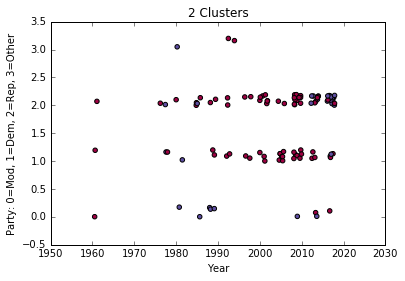

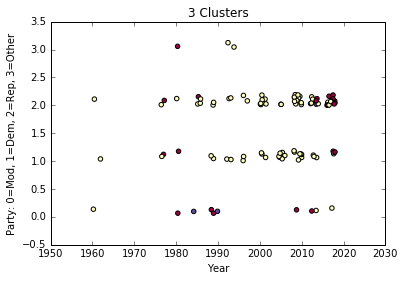

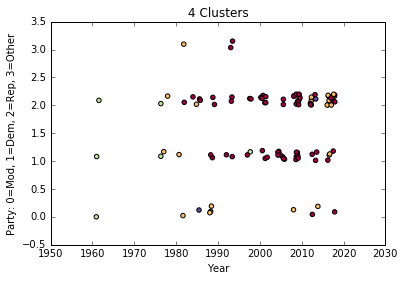

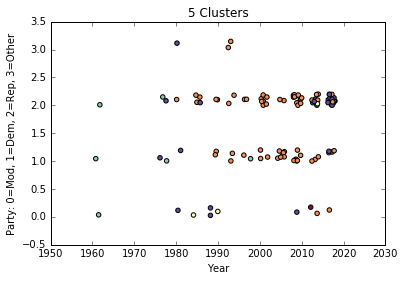

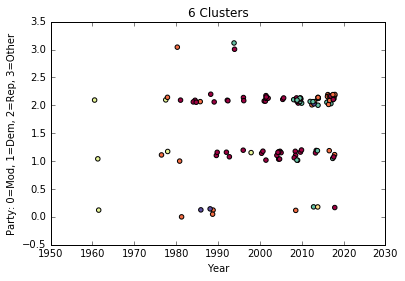

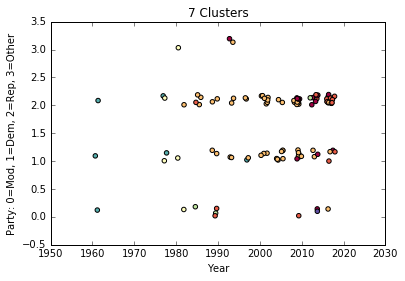

In [504]:
parties = pd.read_csv('party_names.csv',index_col='id')
build_plots(parties,raw_scores,'even')

In [465]:
# Add noise to spread out points
year = [float(x) + np.random.random()*2 for x in joined_df['year_num']]
party = [float(x) + np.random.random()*.2 for x in joined_df['party_name']]


In [503]:
def build_plots(parties,raw_scores,name):
    for num_clusters in range(2,8):
        cluster_df = add_clusters(raw_scores,added_fields,num_clusters)
        score_df = build_distance_matrix(cluster_df,dist_dict)
        joined_df = score_df.join(parties)        
        year = [float(x) + np.random.random()*2 for x in joined_df['year_num']]
        party = [float(x) + np.random.random()*.2 for x in joined_df['party_name']]
        joined_df.drop('full_text',axis=1,inplace=True)
        joined_df.to_csv('clusters/' + name + '_' + 'clusters_' + str(num_clusters)+ '.csv')
        plt.scatter(year,party,c=joined_df['clusters'],cmap='Spectral')
        plt.title(str(num_clusters) + ' Clusters')
        plt.xlabel('Year')
        plt.ylabel('Party: 0=Mod, 1=Dem, 2=Rep, 3=Other')
        plt.savefig('clusters/' + name + '_' + str(num_clusters) + '_Clusters.png')
        plt.show()
        